# Xray Image classification with Deeplearning(Pytorch)

Author: Clarke Lee | Date:12/09/2022 | Contact: ccark.d.lee@gmail.com

## Loading dependencies

In [1]:
#*** Work enviroment setup, Loading dependencies ****

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import matplotlib.pyplot as plt #graph and chart tools
import numpy as np # linear algebra
import PIL #imagging process liberay
from PIL import Image

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#********** Pytorch ***********
import torch
import torchvision
import torchvision.transforms as transforms #for transformation of data
from torchvision.io import read_image #the read the tensor as image
from torchvision import datasets #the function to load dataset
import torch.nn as nn # Neural net class to from the neural network
import torch.nn.functional as F #the function collection to build the deep learning network
import torch.optim as optim # optimzer

#********* Useful function ********
import os # the operation system framework
# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import pickle
import helper

In [2]:
# Customer code for display image from tensor
# Original source
#https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/helper.py.

# !wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py

# Creat classicfication CNN for the Image

The layout of the CNN in the model as following:
 * Convlution Layer
 * Maxpooling Layer 
 * Convlution Layer
 * Maxpooling Layer
 * Convlution Layer
 * Maxpooling Layer
 * Dropout Layer
 * Flatening Layer
 * Dense Layer
 * Dense Layer

## Choose parameter for the CNN

Input_channel, because the image are X-ray negatives, they are only balck and white image. Hence there are only one channel. In other word. We will have only one input channel and 

The size of the output is an important parameter. For square images there is one fomura to caulate the output. For rectangular images, the same formula can be used in for each dimension independently.
Let M be the size of the input and K be the size of the kernel. The size of the output is given by the following formula:

    𝑀𝑛𝑒𝑤=𝑀−𝐾+1
    

In [3]:
# Convolutiona Neural Network



class CNN_net(nn.Module):
    ''' Convolution Neural Networrk Structure '''
    def __init__ (self,out_1 = 32,out_2 = 64, out_3 = 128):
        '''initialize the network with supper class'''
        super(CNN_net,self).__init__()
        # 3 channel image channel, 6 output channels,
        # 5 x 5 convolution kernal
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 0)
        
        #Max pooling over a (2,2) window
        self.pool1 = nn.AdaptiveMaxPool2d(5)
        
        self.conv2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, stride = 1,padding = 0)
        
        self.pool2 = nn.AdaptiveMaxPool2d(5)
        
        self.conv3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, stride = 1,padding = 0)
        
        self.pool3 = nn.AdaptiveMaxPool2d(5)
        
        self.dropout = nn.Dropout(p=0.2) #dropout function to increase speed of the training
    
        self.fc1 = nn.Linear(out_3 * 5 * 5, 120) # 5 x 5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = torch.flatten(x,1) #flatten all dimensions except batch
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
#     def forward(self, x):
#         '''the forward propagation algorithm'''

#         x = self.pool1(F.relu(self.conv1(x)))
        
#         x = self.pool2(F.relu(self.conv2(x)))
        
#         x = x.view(x.size(0),-1)
        
#         x = F.relu(self.fc1(x))
        
#         x = F.relu(self.fc2(x))
        
#         return x
    
    # Output in each steps 
    # Output in each steps 
    def activations(self,x):
        #outputs activation is not necessary 
        #but this function give opertunity to see the outcome from each of the layers. 
        z1  = self.conv1(x)
        a1  = torch.relu(z1)
        out = self.pool1(a1)
        
        z2  = self.conv2(out)
        a2  = torch.relu(z2)
        out1= self.pool2(a2)
        out = out.view(out.size(0),-1) 
    
        return z1, a1, z2, a2, out1, out
    

## Create a CNN network 
Build a CNN model with 16 output channels in first layer and 32 channels in 2nd layer

In [4]:
# Create a CNN model
model = CNN_net(out_1 =32, out_2 = 64)
print(model)

CNN_net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AdaptiveMaxPool2d(output_size=5)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AdaptiveMaxPool2d(output_size=5)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): AdaptiveMaxPool2d(output_size=5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=3200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Data Preparetion and Handling
## First Step: Created dataset from the directory
Create two datasets, one for train one for varification.

In [5]:
#Python method walk() generates the file names in a directory tree by walking the tree either top-down or bottom-up.

# Download chest-xray-pneumonia dataset
# Create the training data set directory
data_lists_train=[]


#*** Create the train data set
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'):
    for filename in filenames:
         data_lists_train.append(os.path.join(dirname, filename))   #all files directary has stored into the list.

print("This is the first item of the list",data_lists_train[0])

data_lists_train.pop(0) # remove the first item in the list

print("After removed the unwant file name",data_lists_train[0] )


#***** Create the training data set directory
data_list_test=[]
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/'):
    for filename in filenames:
         data_list_test.append(os.path.join(dirname, filename))   #all files directary has stored into the list.

print("This is the first item of the list",data_list_test[0])

data_list_test.pop(0) # remove the first item in the list

print("After removed the unwant file name",data_list_test[0] )

            
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This is the first item of the list /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/.DS_Store
After removed the unwant file name /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg
This is the first item of the list /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/.DS_Store
After removed the unwant file name /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person1676_virus_2892.jpeg


## Examine the Image

Review the images which are for the later use.

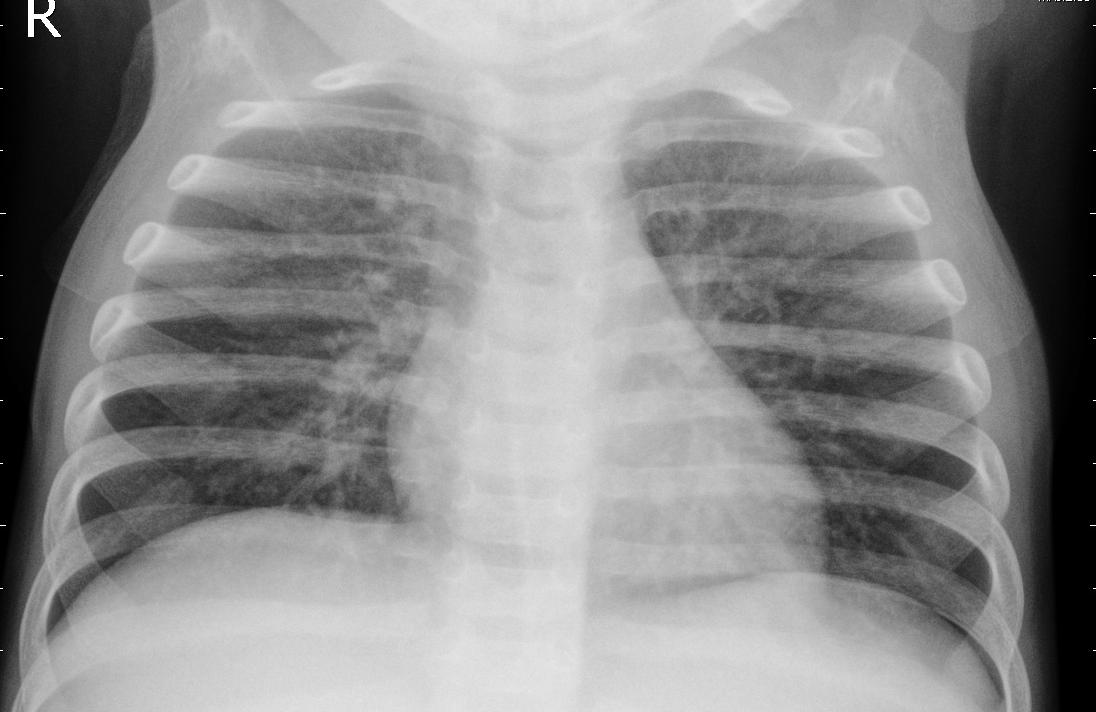

In [6]:
image_t = Image.open(data_lists_train[2])
image_t

image_test = Image.open(data_list_test[2])
image_test
# newsize = (200, 200)
# im1 = image_test.resize((500,500))

#image_t._size

## Step two :Load and Normalize data

In this step, the dataset shall be transform to the tensos, then dataset will be normalized. The normalized data helps the CNN to learn faster and better.

In [7]:
"""Transform"""

#**  Data directry ****

dataset_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'

#path_train = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
#path_test = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/'

#set batch_size = 32

batch_size = 32

# set number of workers

num_workers = 2

#** Premeter for the normalization
mean = (0.5,0.5,0.5)
std = (0.5,0.5,0.5)


#****  Data transformation config *****

transform_train = transforms.Compose(# compose serveral transformation together
    [transforms.Resize((256,256)), #unified the size of the image and reduce computational cost
     #transforms.ToPILImage(),
     transforms.ToTensor(),  # Trasform to Tensor object
     transforms.Normalize(mean,std)] #  Normalizing the tensor
)

transform_test = transforms.Compose(# compose serveral transformation together
    [transforms.Resize((256,256)), #unified the size of the image and reduce computational cost
     #transforms.ToPILImage(),
     transforms.ToTensor(),  # Trasform to Tensor object
     transforms.Normalize(mean,std)] # Normalizing the tensor
)

''' Transform all data set into tensors'''
# Transform image into tensor for training and testing

dataset_train = datasets.ImageFolder(dataset_path + '/train', transform = transform_train)
dataset_test  = datasets.ImageFolder(dataset_path + '/test', transform = transform_test)

''' Image loader '''
# Loading the images into the batches with corresponded labels for future process.
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size = batch_size,shuffle=True,num_workers=num_workers)
dataloader_test  = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size,num_workers=num_workers)

# There are two classes in the set
classes = ('NORMAL','PNEUMONIA')

## Testcode

Test the transformation of the images. Data loader is a generator and to get data out of it, we need to loop through it or convert it to an iterator and call next()

## Visualize Images

In [8]:
#check the size of image

trainimages,trainlables = next(iter(dataloader_train))
#iter() return iterator object; next() return the next value in the iterator object.


print(trainimages[1].size())

torch.Size([3, 256, 256])


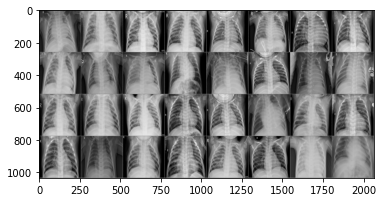

PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA


In [9]:
  ''' function to show image '''
def imshow(img):

    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert to numpy objects
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random training images with iter function
dataiter = iter(dataloader_train)
images, labels = dataiter.next()

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [10]:
len(torchvision.utils.make_grid(images))


3

# Model Training
## Step one: Define a Loss Function and optimizer
CrossEntropyLoss is used as Loss function, where stochastic gradient descent(SGD) is the optimizer. 


In [11]:
''' Loss Function and Optimizer'''
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

#The optimizer updates model parameter using the learning rate and gradient
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)
# optimizer = optim.SGD(model_1.parameters(),lr=learning_rate,momentum=0.9)

'''
optim.SGD → Implements stochastic gradient descent
net.parameters() → gets the learnable parameters of the CNN
lr → learning rate of the gradient descent (how big of a step you take)
momentum → momentum helps accelerate gradient vectors in the right directions, which leads to faster converging.

'''



'\noptim.SGD → Implements stochastic gradient descent\nnet.parameters() → gets the learnable parameters of the CNN\nlr → learning rate of the gradient descent (how big of a step you take)\nmomentum → momentum helps accelerate gradient vectors in the right directions, which leads to faster converging.\n\n'

## Step two: Train the Network

This is timed training process. The torch.cuda.Event() function is the proper way to time the training process.

In [12]:
#*** used for time the process of the training

# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)

# Training parameter
n_epochs = 10        # number of time will model train
cost_list = []       # list of cost for each training
accuracy_list = []   # list of cost for each training

#Size of the validation dataset
N_test = len(dataset_test)

#training model function

def model_training(n_epochs):

    for epoch in range(n_epochs): #loop over the dataset multiple times
    
        running_loss = 0
        
        for x, y in dataloader_train:
            
            #Reset the calculated gradient value to prevent gradient accumulates during each loop
            optimizer.zero_grad()
            
            # Makes a prediction based on X value
            z = model(x)
            
            # Measure the loss between prediction and actual Y value
            loss = criterion(z,y)
            
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            
            #Cumulates loss
            running_loss += loss.data
            
        # Save cost of training data of epoch
        cost_list.append(running_loss)
        
        print("The cost of prediction",cost_list[epoch])
        # Keeps track of correct predictions
        correct = 0
        
        # Test the model with the test dataset
        for x_test,y_test in dataloader_test:
            
            # Make prediction 
    
            z=model(x_test)
            # The class with the max value is the one predicted
            _,yhat = torch.max(z.data,1)
            #Checks if the prediction matches the actual value
            correct += (yhat == y_test).sum().item()
            
            
        # Calcualate accuracy and save it
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        
        print("The result of train:",accuracy_list[epoch])
     

    
# #the start of the timing cycle
# start.record()

# model_training()
            
# # the end of the timing cycle
# end.record()

# # Waits for everything to finish running
# torch.cuda.synchronize()

# print('Finished Training')
# print(start.elapsed_time(end))  # milliseconds


In [13]:
model_training(n_epochs)
            

The cost of prediction tensor(176.2714)
The result of train: 0.625
The cost of prediction tensor(96.7830)
The result of train: 0.625
The cost of prediction tensor(94.5806)
The result of train: 0.625
The cost of prediction tensor(72.4566)
The result of train: 0.7996794871794872
The cost of prediction tensor(27.5980)
The result of train: 0.8125
The cost of prediction tensor(23.2211)
The result of train: 0.7275641025641025
The cost of prediction tensor(18.5360)
The result of train: 0.6746794871794872
The cost of prediction tensor(16.0816)
The result of train: 0.8205128205128205
The cost of prediction tensor(16.8320)
The result of train: 0.7660256410256411
The cost of prediction tensor(16.2270)
The result of train: 0.782051282051282


In [14]:
# Save the trained model

PATH = '/Kaggle'


torch.save(model.state_dict(), PATH)

END
________________ 